In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diametery.fiber import Image
from scipy.optimize import curve_fit
from PIL import Image, ImageOps
from typing import Tuple, List
import cv2
import os
import json
#from sklearn.metrics import mean_squared_error

point = Tuple[float,float]
line = Tuple[point, point]
measurements = List[line]

In [2]:
def load_task(file_path):
    # Load an image
    im = Image.open(os.path.join(file_path))
    im = np.array(ImageOps.grayscale(im))
    #im = im.reshape(im.shape+(1,)).astype(np.float32)/255 # one channel image
    # Load segmentation
    seg:np.ndarray = np.load(os.path.join(file_path + '_seg'))['y']
    with open(file_path + "_params") as file:
        params = {int(k):v for k,v in json.load(file).items()}

    return im, seg, params

def select_point_and_fiber(seg):
    # Select a random point that is not background, return the mask for the fiber that the point touches.
    mask_all = seg > 0
    possible_points = np.argwhere(mask_all)
    point_index = np.random.randint(0, possible_points.shape[0]-1)
    point = possible_points[point_index]
    fiber_id = seg[point[0], point[1], point[2]]
    mask = seg == fiber_id
    selected_seg = np.zeros_like(seg, dtype=np.float32)
    selected_seg[mask] = 1.0
    return point[0:2], selected_seg, fiber_id

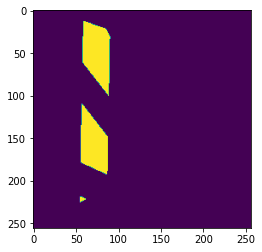

In [6]:
path_3D = '/Users/carmenlopez/dev/diameterY/scratch/dataset_files_3D/test0000'
im_3D, seg, params = load_task(path_3D)
point, selected_seg, fiber_id = select_point_and_fiber(seg)
selected_seg = selected_seg.reshape(selected_seg.shape[0:2])
plt.imshow(selected_seg)
d_m = params[fiber_id]['d']
true_diameter = d_m * (im_3D.shape[0])

In [11]:
def get_coordinates(im, value_for_mask):
    #I = rgb2gray(I_orig) #we can delete this if we get binary images
    mask = im > value_for_mask
    fiber_coor = np.argwhere(mask)
    x = fiber_coor[:, 1]
    y = fiber_coor[:, 0]
    return x, y

def func_line(x, a, b):
    return a * x + b
def func_line_inv(y, a, b):
    return (y - b)/a

def create_fiber():
    image = Image.create()
    im = image.render_image()
    return im, image.fiber.diameter

def get_fited_line_x_y(im):
    value_for_mask = (int(np.max(im))+int(np.min(im)))/2 # Pixels to mask in get_coordinate
    x, y = get_coordinates(im, value_for_mask)
    popt, pcov = curve_fit(func_line, x, y)
    return x, y, popt, pcov
def get_fited_line_y_x(im):
    value_for_mask = (int(np.max(im))+int(np.min(im)))/2 # Pixels to mask in get_coordinate
    x, y = get_coordinates(im, value_for_mask)
    popt, pcov = curve_fit(func_line, y, x)
    return x, y, popt, pcov

def get_better_fit(x, popt, popt_inv, pcov, pcov_inv):
    diagonal = np.diagonal(pcov)
    diagonal_inv = np.diagonal(pcov_inv)
    if np.less(diagonal, diagonal_inv).all() == True:
        popt_fit = popt
        x_line = np.arange(0, max(x), 1)
        y_line = []
        for i in x_line:
            a = func_line(x_line[i], *popt)
            y_line.append(a)
        y_fit = y_line
        x_fit = x_line
        p1 = [x_fit[0],y_fit[0]]
        p2 = [x_fit[-1],y_fit[-1]]
    elif np.less(diagonal, diagonal_inv).all() == False:
        popt_fit = [1/popt_inv[0], (-popt_inv[1])/popt_inv[0]]
        y_line = np.arange(0, max(y), 1)
        x_line = []
        for i in y_line:
            a = func_line(y_line[i], *popt_inv)
            x_line.append(a)
        y_fit = y_line
        x_fit = x_line
        p1 = [x_fit[0],y_fit[0]]
        p2 = [x_fit[-1],y_fit[-1]]
    else:
        print("One of the pcov values is True and the rest are False")
    return popt_fit, x_fit, y_fit, p1, p2

def get_point(t, p1, p2):
    dx = p2[0]-p1[0]
    dy = p2[1]-p1[1]
    p = [(dx * t + p1[0]), (dy * t + p1[1])]
    return p, dx, dy

def get_normal_vector(t, dx, dy, p3):
    n = [-dy, dx]
    mag = np.linalg.norm(n)
    nu = n/mag
    u = [(nu[0] * t + p3[0]), (nu[1] * t + p3[1])]
    return u

def inside(im, pos):
    if not (0 <= pos[0] < im.shape[0]):
        return False
    if not (0 <= pos[1] < im.shape[1]):
        return False
    return True

def get_pixels_half (pos_or_neg, pf, im, dx, dy, p3):
    for ts in (range(len(im[0]))):
        u = get_normal_vector((pos_or_neg*(ts+(pf))), dx, dy, p3) 
        test_point = round(u[1]),round(u[0])
        if not inside(im, test_point):
            return None, None
        test = im[test_point[0], test_point[1]] > half
        if test == False:
            pixels = ts - 1
            break
    plt.plot(u[0], u[1], "c.", markersize=12)
    return pixels, (u[0], u[1])
    
def get_calculated_diameter(n_measurements, pf, p1, p2, im) -> Tuple[float, measurements]:
    diameters = []
    lines = []
    for n in range(1, n_measurements+1): 
        t = 1/(n_measurements + 1 )
        p3, dx, dy = get_point((t * n), p1, p2)
        test_point = round(p3[1]),round(p3[0])
        true_point = im[test_point[0], test_point[1]] > half
        if true_point == False:
            continue
        if true_point == True:
            radius_p, cp1 = get_pixels_half(1, pf, selected_seg, dx, dy, p3)
            radius_n, cp2 = get_pixels_half(-1, pf, selected_seg, dx, dy, p3)
            if (radius_p != None) and (radius_n != None):
                equal = abs((max(radius_p, radius_n)-min(radius_p, radius_n))/max(radius_p, radius_n))
                if equal < 0.1:
                    diameters.append(radius_p+radius_n)
                    plt.plot(p3[0], p3[1], 'r.', markersize=12)
            lines.append((cp1,cp2))
    calculated_diameter = np.array(diameters).mean()
    return calculated_diameter, lines

def line_to_arrays(line):
    return [line[0][0], line[1][0]], [line[0][1], line[1][1]]

def mask_measured_lines(im, lines):
    mask = np.zeros_like(im)

    for p1, p2 in lines:
        if not (p1 == None or p2 == None):
            cv2.line(mask, np.array(p1).astype(np.int32), np.array(p2).astype(np.int32), 1, 1)
    return mask



The calculated diameter is : 30.0
The true diameter is : 32.08086445268926


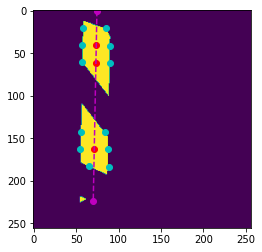

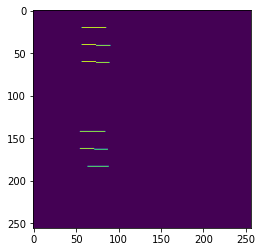

In [12]:
n_measurements = 10 # Number of points to measure along fitted line (red points)
pixel_fraction = 0.3 # Fraction of pixel to test radius of fiber (blue points)

half = (int(np.max(selected_seg))+int(np.min(selected_seg)))/2
x, y, popt, pcov = get_fited_line_x_y(selected_seg)
_, _, popt_inv, pcov_inv = get_fited_line_y_x(selected_seg)
popt_fit, x_fit, y_fit, p1, p2 = get_better_fit(x, popt, popt_inv, pcov, pcov_inv)
calculated_diameter, lines = get_calculated_diameter(n_measurements, pixel_fraction, p1, p2, selected_seg)
mask_meas_lines = mask_measured_lines(selected_seg, lines)

print("The calculated diameter is :", calculated_diameter)
print("The true diameter is :", true_diameter) 

plt.imshow(selected_seg)
plt.plot(x_fit, y_fit, 'm--')
plt.plot(p1[0], p1[1], 'm.', markersize=12)
plt.plot(p2[0], p2[1], 'm.', markersize=12)
#for line in lines:
   #plt.plot(*line_to_arrays(line), 'c-')
plt.show()
plt.imshow(mask_meas_lines)
